<a href="https://colab.research.google.com/github/briannewjawn/IST597/blob/main/ist597hw00010fmnistddd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the Libraries

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf

np.random.seed(3147)

In [ ]:
import matplotlib.pyplot as plt

Generate random data

In [ ]:
size_input = 784
size_hidden1 = 128
size_hidden2 = 128
size_output = 10



In [ ]:
#Import Mnist Dataset

(X_train,y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_val = X_train[50000:60000]
X_train =X_train[0:50000]
y_val = y_train[50000:60000]
y_train=y_train[0:50000]


In [ ]:
#Reshape Data
X_train= X_train.reshape(50000, 784)
X_val = X_val.reshape(10000,784)
X_test= X_test.reshape(10000, 784)

In [ ]:
#normalize x value to 0-1
X_train = tf.keras.utils.normalize(X_train, axis = 1)
X_val = tf.keras.utils.normalize(X_val, axis = 1)
X_test = tf.keras.utils.normalize(X_test, axis = 1)

#change y value to one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, size_output)
y_val = tf.keras.utils.to_categorical(y_val, size_output)
y_test = tf.keras.utils.to_categorical(y_test, size_output)



In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(256)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


Build MLP using Eager Execution

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden1,size_hidden2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_output, device
    
    # Initialize weights between input layer and hidden layer 1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1]))
    # Initialize biases for hidden layer 1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden1]))
     # Initialize weights between hidden layer 1 and hidden layer 2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2]))
    # Initialize biases for hidden layer 2
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden2]))
    # Initialize weights between hidden layer 2 and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.Wvariables = [self.W1, self.W2, self.W3]
    
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    regularizerL1L2 = tf.keras.regularizers.L1L2()
    regularizerL2 = tf.keras.regularizers.L2()
    lossL1L2 = tf.add_n([regularizerL1L2(v) for v in self.Wvariables ])
    
    lossL2 = tf.add_n([regularizerL2(v) for v in self.Wvariables ])
    return tf.keras.losses.categorical_crossentropy(y_true_tf, y_pred_tf) + lossL1L2*0.9
    #return regularizer(tf.keras.losses.categorical_crossentropy(y_true_tf, y_pred_tf))


  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer 1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer 2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.nn.softmax(tf.matmul(hhat2, self.W3) + self.b3)
   
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

Train Model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 15


Number of Epoch = 1 - Average Training Lost:= 10.7343825
Training Accuracy = 45.34800052642822
Number of Epoch = 2 - Average Training Lost:= 7.957598125
Training Accuracy = 54.05200123786926
Number of Epoch = 3 - Average Training Lost:= 7.233955
Training Accuracy = 54.99799847602844
Number of Epoch = 4 - Average Training Lost:= 7.100541875
Training Accuracy = 55.57600259780884
Number of Epoch = 5 - Average Training Lost:= 6.92893125
Training Accuracy = 55.70799708366394
Number of Epoch = 6 - Average Training Lost:= 5.6757075
Training Accuracy = 69.52999830245972
Number of Epoch = 7 - Average Training Lost:= 0.723988359375
Training Accuracy = 79.36999797821045
Number of Epoch = 8 - Average Training Lost:= 0.5844152734375
Training Accuracy = 81.31600022315979
Number of Epoch = 9 - Average Training Lost:= 0.5343752734375
Training Accuracy = 82.10600018501282
Number of Epoch = 10 - Average Training Lost:= 0.50467640625
Training Accuracy = 82.5160026550293
Number of Epoch = 11 - Average Tra

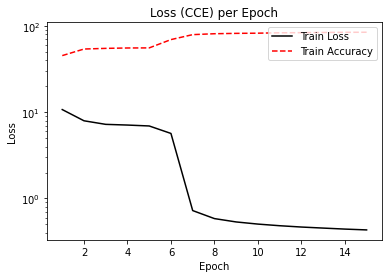

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden1,size_hidden2, size_output, device='gpu')
###
x= list(range(1, 16))
y1=[]
y2=[]
#correct_predictions =tf.Variable(0, dtype=tf.float32)
###
time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  loss_total_v = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracytrain = []
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(3147)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
    ####
    #train_accuracy_metric.update_state(tf.argmax(outputs), tf.argmax(preds))
    #if prediction = true value then increment correctioon prediciton
    #for i in range(preds.shape[0]):
        #if tf.argmax(preds[i])== tf.argmax(outputs[i]):
          #correct_predictions = correct_predictions + 1.0
  ####
  #train_accuracy = train_accuracy_metric.result().numpy()
  #accuracytrain = correct_predictions/X_train.shape[0]*100
  train_accuracy_metric = tf.metrics.CategoricalAccuracy()
  y1.append( np.sum(loss_total_gpu) / X_train.shape[0])
  accuracytrain.append(train_accuracy_metric(mlp_on_default.forward(X_train),y_train))
  y2.append(np.mean(accuracytrain)*100)
  ##########VALIDATION SET
  
 

  #print("test",train_accuracy)
  print('Number of Epoch = {} - Average Training Lost:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / X_train.shape[0]))
  print('Training Accuracy = {}'.format(np.mean(accuracytrain)*100))

  
  # Reset training metrics at the end of each epoch
  #correct_predictions =tf.Variable(0, dtype=tf.float32)
  #train_accuracy_metric.reset_state()
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#### GRAPH
plt.plot(x, y1 , 'k-', label='Train Loss')
plt.plot(x,y2, 'r--', label='Train Accuracy')
plt.title('Loss (CCE) per Epoch')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.yscale("log")
plt.ylabel('Loss')
plt.show()

Validation

In [ ]:
NUM_ValidationE = 5
time_start = time.time()
for validation in range(NUM_ValidationE):
  loss_total_v = tf.zeros([1,1], dtype=tf.float32)
  ltv = 0
  validationtrain = []
  for vinputs, voutputs in val_ds:
    valpreds = mlp_on_default.forward(vinputs)
    loss_total_v = loss_total_v + mlp_on_default.loss(valpreds, voutputs)
    ltv = ltv + mlp_on_default.loss(valpreds, voutputs)
  val_accuracy_metric = tf.metrics.CategoricalAccuracy()
  validationtrain.append(val_accuracy_metric(mlp_on_default.forward(X_val),y_val))

  print('Number of Epoch = {} Validation Lost:= {}'.format(validation + 1, np.sum(loss_total_v) / X_val.shape[0]))
  print('Validation Accuracy = {}'.format(np.mean(validationtrain)*100))
  
 
time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

One Step Inference

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_test_prediction = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0

for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
  
  
  for i in range(preds.shape[0]):
    if tf.argmax(preds[i])== tf.argmax(outputs[i]):
      correct_test_prediction = correct_test_prediction + 1.0
  

# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
accuracytest = correct_test_prediction/X_test.shape[0]*100
print('Test CCE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0]))
print('test accuracy = {}'.format(accuracytest))




Test CCE: 0.1048
test accuracy = 81.7300033569336


[1, 2, 3, 4, 5, 6, 7, 8, 9]

Test EPOCH

Graphs

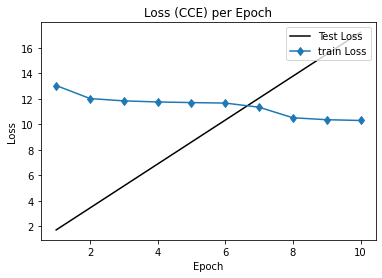

In [ ]:
plt.plot(x, ytest , 'k-', label='Test Loss')
plt.plot(x, y1 , 'd-', label='train Loss')
plt.plot()
plt.title('Loss (CCE) per Epoch')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()